# Predição de Notas no Cartola

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

sns.set(style="darkgrid", color_codes=True)

### Descrição dos dados

Nesta tarefa construiremos modelos preditivos de regressão para a predição de notas de jogadores no Cartola (2014).

- atleta_id: Referência ao atleta
- rodada_id: Rodada atual
- clube_id: Referência ao clube
- posicao_id: Referência à posição
- status_id: Referência ao status
- pontos_num: Pontos obtidos na rodada atual
- preco_num: Preço atual
- variacao_num: Variação de Preço desde a última rodada
- media_num: Média de pontos por rodada jogada
- jogos_num: Número de partidas jogadas
- FS: Faltas sofridas
- PE: Passes perdidos
- A: Assistências
- FT: Chutes na trave
- FD: Chutes defendidos
- FF: Chutes
- G: Gols
- I: Impedimentos
- PP: Penaltis perdidos
- RB: successful tackes
- FC: Faltas cometidas
- GC: Gols contra
- CA: Cartões amarelos
- CV: Cartões vermelhos
- SG: Sem gols (apenas defesa)
- DD: Defesas difíceis (somente goleiros)
- DP: Penaltis defendidos (somente goleiros)
- GS: Gols sofridos (somente goleiros)
- **Nota**: variável alvo

In [2]:
#df = pd.read_csv('https://raw.githubusercontent.com/nailsoncunha/ml_cartola/master/cartola_2014.csv')
df = pd.read_csv('cartola_2014.csv')
df.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,...,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,...,0,0,0,0,0,0,1,1,0,0
1,68873,1,262.0,0,1.0,0,0.0,0.0,4.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,...,0,0,1,0,1,0,1,0,0,0
3,71602,1,262.0,0,2.0,0,0.0,0.0,3.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,...,0,2,1,0,0,0,1,0,0,0


### Conferindo valores ausentes

In [3]:
df.isnull().sum()

atleta_id       0
rodada          0
clube_id        0
participou      0
posicao_id      0
jogos_num       0
pontos_num      0
media_num       0
preco_num       0
variacao_num    0
partida_id      0
mando           0
titular         0
substituido     0
tempo_jogado    0
nota            0
FS              0
PE              0
A               0
FT              0
FD              0
FF              0
G               0
I               0
PP              0
RB              0
FC              0
GC              0
CA              0
CV              0
SG              0
DD              0
DP              0
GS              0
dtype: int64

## EDA

In [4]:
df.describe()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,...,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
count,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,...,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000
mean,68725.887061,18.488247,150.176467,0.362390,1.886033,6.363487,0.977100,1.588483,5.599905,-0.000048,...,0.000617,0.310958,0.397272,0.000788,0.053008,0.002193,0.043483,0.034265,0.000411,0.027104
std,16655.955349,10.378876,141.539948,0.480699,2.029297,7.484913,2.768579,2.056103,4.704520,0.736660,...,0.024828,0.832903,0.934368,0.028063,0.224360,0.046779,0.204113,0.291499,0.020274,0.238900
min,36443.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-12.000000,-12.000000,0.760000,-7.240000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,60784.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,72491.000000,18.000000,263.000000,0.000000,1.000000,3.000000,0.000000,0.970000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,82463.000000,27.000000,284.000000,1.000000,4.000000,10.000000,0.300000,2.880000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89898.000000,36.000000,316.000000,1.000000,6.000000,36.000000,31.900000,22.100000,29.610000,14.800000,...,1.000000,9.000000,10.000000,1.000000,2.000000,1.000000,1.000000,7.000000,1.000000,6.000000


In [5]:
df

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,...,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,...,0,0,0,0,0,0,1,1,0,0
1,68873,1,262.0,0,1.0,0,0.0,0.0,4.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,...,0,0,1,0,1,0,1,0,0,0
3,71602,1,262.0,0,2.0,0,0.0,0.0,3.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,...,0,2,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179,89637,36,0.0,0,0.0,1,0.0,1.2,2.19,0.00,...,0,0,0,0,0,0,0,0,0,0
29180,89676,36,0.0,0,0.0,1,0.0,-0.5,0.81,0.00,...,0,0,0,0,0,0,0,0,0,0
29181,89681,36,0.0,0,0.0,0,0.0,0.0,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
29182,89885,36,0.0,0,0.0,0,0.0,0.0,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0


### Verificando algumas correlações com a variável alvo

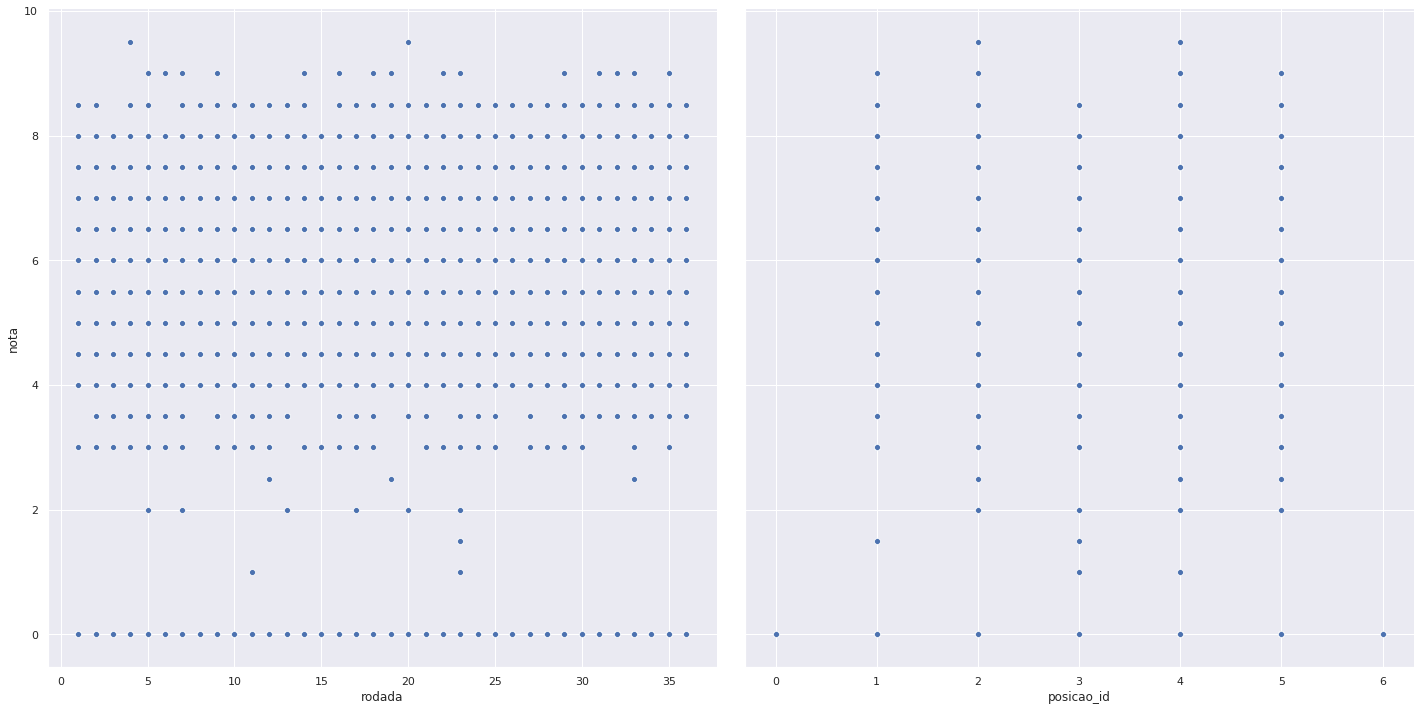

In [6]:
sns.pairplot(df,
             x_vars=['rodada', 'posicao_id'],
             y_vars=['nota'], height = 10)

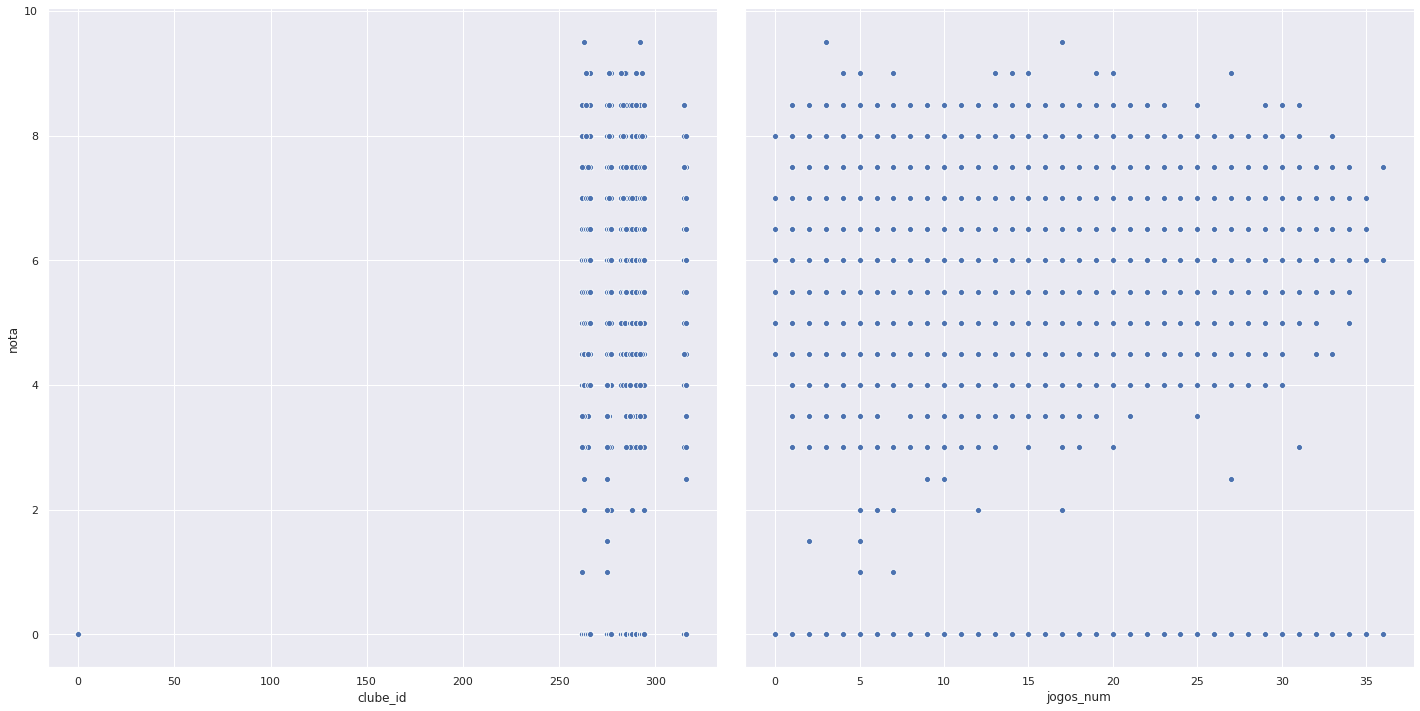

In [7]:
sns.pairplot(df,
             x_vars=['clube_id', 'jogos_num'],
             y_vars=['nota'], height = 10)

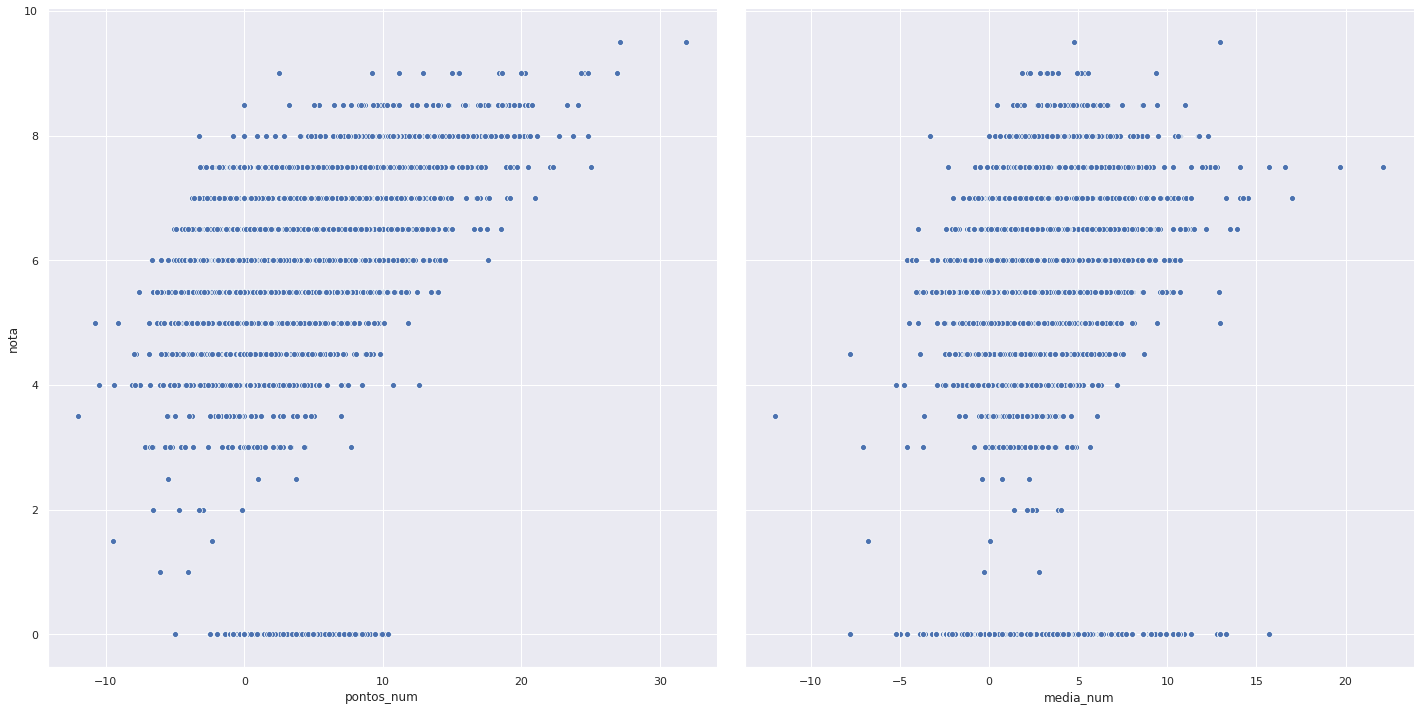

In [8]:
sns.pairplot(df,
             x_vars=['pontos_num', 'media_num'],
             y_vars=['nota'], height = 10)

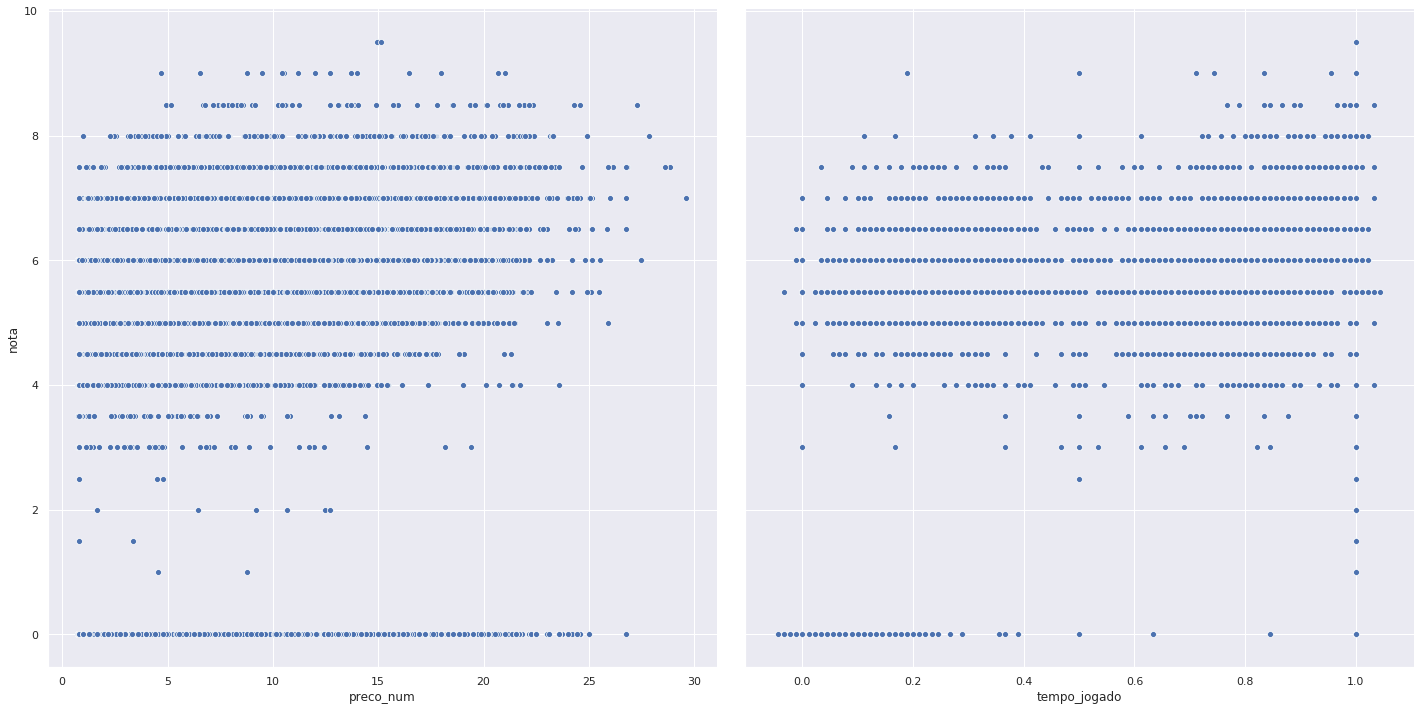

In [9]:
sns.pairplot(df,
             x_vars=['preco_num', 'tempo_jogado'],
             y_vars=['nota'], height = 10)

### Preprocessamento dos dados

- Removendo colunas atleta_id e partida_id
- Codificando variáveis categóricas
- Feature scaling nas variáveis numéricas

In [10]:
df = df.drop(columns=['atleta_id', 'partida_id'])

y_train = df.loc[:, 'nota'].values
df = df.drop(columns=['nota'])
    
preprocess = make_column_transformer(
        (StandardScaler(), ['rodada', 'participou', 'jogos_num', 'pontos_num', 'media_num',
          'preco_num', 'variacao_num', 'mando', 'titular', 'substituido', 'tempo_jogado',
          'FS', 'PE', 'A', 'FT', 'FD', 'FF', 'G', 'I','PP', 'RB', 'FC', 'GC', 'CA', 'CV', 'SG', 
          'DD', 'DP', 'GS']),
        (OneHotEncoder(categories='auto'), ['clube_id', 'posicao_id'])
    )
    
X_train = preprocess.fit_transform(df)

## Modelo Ridge com Cross-Validation

- Testando 50 lamdas de 0.1 a 0.00001 igualmente uniformemente espaçados numa escala de log

In [15]:
lambdas = np.logspace(-5, -1, 50)
ridge = RidgeCV(alphas = lambdas, fit_intercept=True, cv=10)
ridge.fit(X_train, y_train)

print('Melhor lambda encontrado: %0.5f' %ridge.alpha_)

#ridge.cv_values_
#ridge.score(X_train, y_train)
#ridge.get_params()
#y_pred = ridge.predict(X_train)
#math.sqrt(mean_squared_error(y_train, y_pred))

Melhor lambda encontrado: 0.00001


### Variáveis mais importantes para o modelo Ridge
- Variáveis que possuem os maiores coeficientes (>= 0.1)

In [16]:
important_variables = []
club_plus_position = 0
for i in range(len(ridge.coef_)):
    if abs(ridge.coef_[i]) >= 0.1:
        if(i < len(df.drop(columns=['clube_id', 'posicao_id']).columns)):
            important_variables.append(df.drop(columns=['clube_id', 'posicao_id']).columns[i])
        else:
            club_plus_position += 1
print('Variáveis mais importantes para o Ridge: ', important_variables)
print('Juntamente com %d variáveis referentes a posição do jogador e id do clube' %(club_plus_position))

Variáveis mais importantes para o Ridge:  ['participou', 'titular', 'substituido', 'tempo_jogado', 'A', 'G', 'SG', 'DD']
Juntamente com 13 variáveis referentes a posição do jogador e id do clube


## Modelo Lasso com cross-validation